In [ ]:
!pip install nltk

In [ ]:
!pip install KeyBERT

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 

In [ ]:
import nltk
import keybert
from keybert import KeyBERT
import os
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import numpy as np
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel
from gensim.models import LsiModel
from gensim.models import HdpModel
from gensim.models import LdaMulticore
from gensim.models import EnsembleLda
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.utils import tokenize
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
nltk.download('wordnet')
import re
import json
import string
from bs4 import BeautifulSoup
from gensim.parsing.preprocessing import (
    strip_non_alphanum,
    split_alphanum,
    strip_short,
    strip_numeric
)
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
datafile = 'latest_ticket_data.csv'
data = pd.read_csv(datafile)

In [ ]:
data['Description'] = data['Description'].str.lower()
data['Description'] = data['Description'].astype(str)

In [ ]:
stop_words = stopwords.words('english')
custom_stop_words = ['hi', 'since', 'please', 'best', 'regards', 'thank', 'thanks', 'hello', 'sent', 'great', 'dear', 'help', 'kind']
time_words = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'today' , 'yesterday', 'tomorrow', 'hour', 'hours', 'time', 'times', 'timelines', 'date', 'day', 'days', 'am', 'pm', 'morning', 'noon', 'afternoon', 'evening', 'night', 'winter', 'summer', 'rain', 'cold']

def remove_stop_words(text):
    pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
    text = pattern.sub('', text)
    return text

def remove_custom_words(text):
    pattern = re.compile(r'\b(' + r'|'.join(custom_stop_words) + r')\b\s*')
    text = pattern.sub('', text)
    return text

def remove_time_words(text):
    pattern = re.compile(r'\b(' + r'|'.join(time_words) + r')\b\s*')
    text = pattern.sub('', text)
    return text

data['Description'] = data["Description"].map(lambda x: remove_stop_words(x))
data['Description'] = data["Description"].map(lambda x: remove_custom_words(x))
data['Description'] = data["Description"].map(lambda x: remove_time_words(x))

In [ ]:
def parse_html(text, parser="html.parser"):
    soup = BeautifulSoup(text, parser)
    soup = remove_html_tags(soup)
    text = remove_multiple_space(soup.get_text()).strip()
    return text


def parse_html_v2(text, loop=2, parser="html.parser"):
    if not text:
        text = ""
    # some contents still have html code after first parse
    # loop solved problem
    for _ in range(loop):
        soup = BeautifulSoup(text, parser)
        text = soup.get_text()
    text = remove_multiple_space(text)
    return text


def remove_links_content(text):
    text = re.sub(r"http\S+", "", text)
    return text


def remove_emails(text):
    return re.sub('\S*@\S*\s?', '', text)  # noqa


def remove_punctuation(text):
    """https://stackoverflow.com/a/37221663"""
    table = str.maketrans({key: None for key in string.punctuation})
    return text.translate(table)


def remove_special_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('{.*?}')
    return re.sub(clean, '', text)


def preprocess_text(text):
    text = parse_html_v2(text)
    text = text.lower()
    text = remove_links_content(text)
    text = remove_emails(text)
    text = remove_special_tags(text)  # remove content between {}
    text = remove_punctuation(text)  # remove all puntuations
    text = split_alphanum(text)  # add space between word and numeric
    text = strip_numeric(text)  # remove digits
    text = strip_non_alphanum(text)  # remove non-alphabetic characters
    text = strip_short(text, minsize=2)  # remove word with length  <  minsize
    text = remove_multiple_space(text).strip()  # remove space and strip
    #text = tokenize(text)
    return text


def remove_multiple_space(text):
    return re.sub("\s\s+", " ", text)  # noqa


def remove_html_tags(soup,
                     tags=["script", "style"],
                     get_text=False):
    for tag in tags:
        for sample in soup.find_all(tag):
            sample.replaceWith('')

    if get_text:
        return soup.get_text()
    return soup

In [ ]:
# Convert body column to string for performing text operations
data['Description'] = data['Description'].astype(str)
data['Description'] =data["Description"].map(lambda x: preprocess_text(x))

In [ ]:
lemmatizer = WordNetLemmatizer()
data['Lemma_Description'] = data["Description"].map(lambda x: lemmatizer.lemmatize(x))

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


x = data['Lemma_Description'].values.tolist()
docs = list(sent_to_words(x))
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

In [ ]:
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
#Remove rare & common tokens
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 1365
Number of documents: 3000
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [ ]:
# Set parameters.
num_topics = 5
chunksize = 500
passes = 20
iterations = 400
eval_every = 1

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary

In [ ]:
LE = LabelEncoder()
data['Label'] = LE.fit_transform(data['Category'])
print(data)

                                            Description     Category  \
0     recruiter lead permission approve requisitions...  Application   
1     expire ask update passwords colleagues expire ...  Application   
2     verification warning got attached addresses mo...  Application   
3     looks blacklisted receiving mails anymore samp...  Application   
4                       modules report report cost much  Application   
...                                                 ...          ...   
2995  feedback follow conf call setup meeting one co...     Database   
2996  issues keep getting errors errors preventing s...     Database   
2997  en working properly guys issue number en locat...     Database   
2998  log incident laptop engineer managed got feedb...     Database   
2999  connection issues connection issues working cl...     Database   

                                      Lemma_Description  Label  
0     recruiter lead permission approve requisitions...      0  
1    

In [ ]:
from sklearn.metrics import accuracy_score
def getLDAModelAccuracy(model, corpus, dataset, Label):
  get_document_topics = [model.get_document_topics(item) for item in corpus]
  np_array_of_objects = np.asarray(get_document_topics, dtype="object")
  pred_df = pd.DataFrame(columns=['pred_label'])
  length = len(pd.DataFrame(np_array_of_objects)[0])
  dict_list = []
  for i in range(0,length):
    count=len(pd.DataFrame(np_array_of_objects)[0][i])
    max=0
    for j in range(0,count):
      if(max < (pd.DataFrame(np_array_of_objects)[0][i])[j][1]):
        max=(pd.DataFrame(np_array_of_objects)[0][i])[j][1]
        label=(pd.DataFrame(np_array_of_objects)[0][i])[j][0]
    row_dict = {'pred_label': label}
    dict_list.append(row_dict)
  pred_df = pd.DataFrame.from_dict(dict_list)
  y_pred = pred_df['pred_label'].values
  y_true = dataset['Label'].values
  return(accuracy_score(y_true, y_pred))

In [ ]:
#lda model
lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.016*"analyst_ext" + 0.010*"information" + 0.010*"also" + 0.008*"ext" + 0.008*"attached" + 0.008*"let" + 0.008*"engineer" + 0.008*"update" + 0.008*"client" + 0.007*"test"'), (1, '0.019*"could" + 0.019*"let_know" + 0.018*"en" + 0.018*"access" + 0.016*"issue" + 0.015*"laptop" + 0.015*"server" + 0.014*"log" + 0.013*"problem" + 0.013*"need"'), (2, '0.067*"importance_high" + 0.045*"senior_engineer" + 0.030*"leaver" + 0.029*"disk" + 0.026*"high" + 0.024*"engineer" + 0.023*"importance" + 0.022*"senior" + 0.016*"meeting_room" + 0.015*"senior_tester"'), (3, '0.100*"card" + 0.038*"la" + 0.038*"access" + 0.037*"access_card" + 0.037*"lost" + 0.035*"si" + 0.034*"cards" + 0.032*"lost_access" + 0.025*"va" + 0.020*"ca"'), (4, '0.051*"floor" + 0.048*"th_floor" + 0.044*"visitor" + 0.041*"event" + 0.031*"details" + 0.030*"visitor_cards" + 0.027*"area" + 0.024*"details_details" + 0.022*"door" + 0.020*"th"')]


In [ ]:
getLDAModelAccuracy(lda_model,corpus,data,"Label")

0.407

In [ ]:
c_v_coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_lda = c_v_coherence_model_lda.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_lda)


C_V Coherence Score:  0.42828060846916516


In [ ]:
u_mass_coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda = u_mass_coherence_model_lda.get_coherence()
print('\nU_Mass Coherence Score: ', u_mass_coherence_lda)


U_Mass Coherence Score:  -6.783901568140218


In [ ]:
c_uci_coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lda = c_uci_coherence_model_lda.get_coherence()
print('\nc_uciCoherence Score: ', c_uci_coherence_lda)


c_uciCoherence Score:  -5.040997288780671


In [ ]:
c_npmi_coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lda = c_npmi_coherence_model_lda.get_coherence()
print('\c_npmi_Coherence Score: ', c_npmi_coherence_lda)

\c_npmi_Coherence Score:  -0.13138886284429768


In [ ]:
#lda multicore model
lda_multicore_model = LdaMulticore(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_multicore_model.print_topics())

[(0, '0.015*"purchase_po" + 0.013*"receive_item" + 0.010*"find_attached" + 0.010*"item" + 0.009*"receive" + 0.009*"log" + 0.009*"assigned" + 0.009*"administrator" + 0.009*"take" + 0.008*"user"'), (1, '0.074*"importance_high" + 0.039*"floor" + 0.034*"leaver" + 0.029*"visitor" + 0.028*"cards" + 0.027*"name" + 0.027*"visitor_cards" + 0.026*"importance" + 0.023*"area" + 0.020*"high"'), (2, '0.014*"issue" + 0.012*"access" + 0.012*"senior_engineer" + 0.012*"could" + 0.012*"th_floor" + 0.011*"engineer" + 0.011*"en" + 0.011*"working" + 0.010*"let_know" + 0.010*"senior"'), (3, '0.093*"card" + 0.044*"la" + 0.043*"si" + 0.030*"va" + 0.027*"access_card" + 0.024*"ca" + 0.023*"lost_access" + 0.022*"lost" + 0.021*"care" + 0.019*"analyst_ext"'), (4, '0.034*"event" + 0.024*"disk" + 0.014*"original_message" + 0.013*"changed" + 0.013*"details" + 0.012*"host" + 0.012*"senior_tester" + 0.011*"details_details" + 0.011*"information" + 0.011*"starter_form"')]


In [ ]:
getLDAModelAccuracy(lda_multicore_model,corpus,data,"Label")

0.34833333333333333

In [ ]:
c_v_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_lda_multicore = c_v_coherence_model_lda_multicore.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_lda_multicore)


C_V Coherence Score:  0.4545795494181932


In [ ]:
u_mass_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda_multicore = u_mass_coherence_model_lda_multicore.get_coherence()
print('\nu_mass Coherence Score: ', u_mass_coherence_lda_multicore)


u_mass Coherence Score:  -6.369590184069187


In [ ]:
c_uci_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lda_multicore = c_uci_coherence_model_lda_multicore.get_coherence()
print('\nc_uci Coherence Score: ', c_uci_coherence_lda_multicore)


c_uci Coherence Score:  -4.885510001511655


In [ ]:
c_npmi_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lda_multicore = c_npmi_coherence_model_lda_multicore.get_coherence()
print('\nc_npmi Coherence Score: ', c_npmi_coherence_lda_multicore)


c_npmi Coherence Score:  -0.11892735181292236


In [ ]:
LE = LabelEncoder()
data['Label'] = LE.fit_transform(data['Category'])
print(data)

                                            Description     Category  \
0     recruiter lead permission approve requisitions...  Application   
1     expire ask update passwords colleagues expire ...  Application   
2     verification warning got attached addresses mo...  Application   
3     looks blacklisted receiving mails anymore samp...  Application   
4                       modules report report cost much  Application   
...                                                 ...          ...   
2995  feedback follow conf call setup meeting one co...     Database   
2996  issues keep getting errors errors preventing s...     Database   
2997  en working properly guys issue number en locat...     Database   
2998  log incident laptop engineer managed got feedb...     Database   
2999  connection issues connection issues working cl...     Database   

                                      Lemma_Description  Label  
0     recruiter lead permission approve requisitions...      0  
1    

In [ ]:
df_0 = data.loc[(data['Label'] == 0)]
df_1 = data.loc[(data['Label'] == 1)]
df_2 = data.loc[(data['Label'] == 2)]
df_3 = data.loc[(data['Label'] == 3)]
df_4 = data.loc[(data['Label'] == 4)]

In [ ]:
# Instantiate
kw_model = KeyBERT()
# Extract keywords
keywords = df_0['Lemma_Description'].apply(kw_model.extract_keywords)
text = []
for list in keywords:
    for component in list:
        text.append(str(component[0]))
# Bar plot - Create a dataframe of the most common 20 words
common_words = pd.DataFrame(Counter(text).most_common(20))
common_words.columns = ('Word', 'Count')
label_0 = [common_words['Word'][0],common_words['Word'][1], common_words['Word'][2],common_words['Word'][3],common_words['Word'][4]]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Instantiate
kw_model = KeyBERT()
# Extract keywords
keywords = df_1['Lemma_Description'].apply(kw_model.extract_keywords)
text = []
for list in keywords:
    for component in list:
        text.append(str(component[0]))
# Bar plot - Create a dataframe of the most common 20 words
common_words = pd.DataFrame(Counter(text).most_common(20))
common_words.columns = ('Word', 'Count')
label_1 = [common_words['Word'][0],common_words['Word'][1], common_words['Word'][2],common_words['Word'][3],common_words['Word'][4]]

In [ ]:
# Instantiate
kw_model = KeyBERT()
# Extract keywords
keywords = df_2['Lemma_Description'].apply(kw_model.extract_keywords)
text = []
for list in keywords:
    for component in list:
        text.append(str(component[0]))
# Bar plot - Create a dataframe of the most common 20 words
common_words = pd.DataFrame(Counter(text).most_common(20))
common_words.columns = ('Word', 'Count')
label_2 = [common_words['Word'][0],common_words['Word'][1], common_words['Word'][2],common_words['Word'][3],common_words['Word'][4]]

In [ ]:
# Instantiate
kw_model = KeyBERT()
# Extract keywords
keywords = df_3['Lemma_Description'].apply(kw_model.extract_keywords)
text = []
for list in keywords:
    for component in list:
        text.append(str(component[0]))
# Bar plot - Create a dataframe of the most common 20 words
common_words = pd.DataFrame(Counter(text).most_common(20))
common_words.columns = ('Word', 'Count')
label_3 = [common_words['Word'][0],common_words['Word'][1], common_words['Word'][2],common_words['Word'][3],common_words['Word'][4]]

In [ ]:
# Instantiate
kw_model = KeyBERT()
# Extract keywords
keywords = df_4['Lemma_Description'].apply(kw_model.extract_keywords)
text = []
for list in keywords:
    for component in list:
        text.append(str(component[0]))
# Bar plot - Create a dataframe of the most common 20 words
common_words = pd.DataFrame(Counter(text).most_common(20))
common_words.columns = ('Word', 'Count')
label_4 = [common_words['Word'][0],common_words['Word'][1], common_words['Word'][2],common_words['Word'][3],common_words['Word'][4]]

In [ ]:
ps = PorterStemmer()

label_0 = [ps.stem(word) for word in label_0]
label_1 = [ps.stem(word) for word in label_1]
label_2 = [ps.stem(word) for word in label_2]
label_3 = [ps.stem(word) for word in label_3]
label_4 = [ps.stem(word) for word in label_4]

In [ ]:
label_topics = {}
for word in label_0:
    label_topics[word] = 0
for word in label_1:
    label_topics[word] = 1
for word in label_2:
    label_topics[word] = 2
for word in label_3:
    label_topics[word] = 3
for word in label_4:
    label_topics[word] = 4

In [ ]:
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

In [ ]:
eta_label = create_eta(label_topics, dictionary, 5)

In [ ]:
#lda model
label_lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta=eta_label, \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [ ]:
getLDAModelAccuracy(label_lda_model,corpus,data,"Label")

0.23033333333333333

In [ ]:
for num, params in label_lda_model.print_topics():
    print(f'{num}: {params}\n')

0: 0.056*"card" + 0.031*"analyst_ext" + 0.030*"cards" + 0.014*"analyst" + 0.014*"ext" + 0.013*"hub" + 0.011*"information" + 0.009*"consider_environment" + 0.008*"number" + 0.008*"meeting"

1: 0.021*"engineer" + 0.018*"senior_engineer" + 0.013*"senior" + 0.013*"laptop" + 0.013*"leaver" + 0.013*"attached" + 0.011*"badge" + 0.011*"form" + 0.011*"log" + 0.010*"test"

2: 0.046*"visitor" + 0.035*"floor" + 0.032*"visitor_cards" + 0.030*"server" + 0.029*"area" + 0.029*"details" + 0.025*"details_details" + 0.020*"engineer_ext" + 0.019*"door" + 0.019*"event"

3: 0.036*"access" + 0.022*"access_card" + 0.021*"th_floor" + 0.021*"lost" + 0.020*"could" + 0.019*"lost_access" + 0.018*"en" + 0.016*"let_know" + 0.016*"issue" + 0.015*"card"

4: 0.056*"importance_high" + 0.043*"la" + 0.039*"si" + 0.028*"va" + 0.023*"ca" + 0.020*"importance" + 0.018*"care" + 0.017*"se" + 0.017*"purchase_po" + 0.016*"sa"



In [ ]:
c_v_coherence_model_labellda = CoherenceModel(model=label_lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_labellda = c_v_coherence_model_labellda.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_labellda)


C_V Coherence Score:  0.37147300072125367


In [ ]:
u_mass_coherence_model_lda = CoherenceModel(model=label_lda_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda = u_mass_coherence_model_lda.get_coherence()
print('\nU_Mass Coherence Score: ', u_mass_coherence_lda)


U_Mass Coherence Score:  -6.875030768894524


In [ ]:
c_uci_coherence_model_lda = CoherenceModel(model=label_lda_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lda = c_uci_coherence_model_lda.get_coherence()
print('\nc_uciCoherence Score: ', c_uci_coherence_lda)


c_uciCoherence Score:  -5.523450976423748


In [ ]:
c_npmi_coherence_model_lda = CoherenceModel(model=label_lda_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lda = c_npmi_coherence_model_lda.get_coherence()
print('\c_npmi_Coherence Score: ', c_npmi_coherence_lda)

\c_npmi_Coherence Score:  -0.1498968073218895


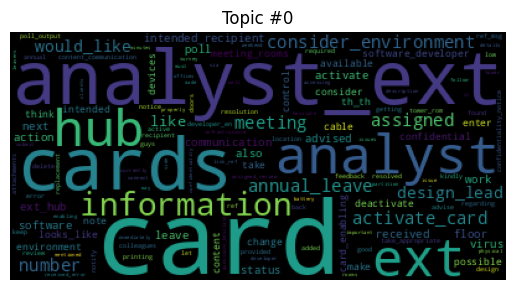

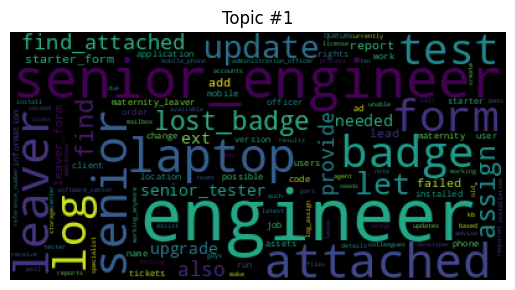

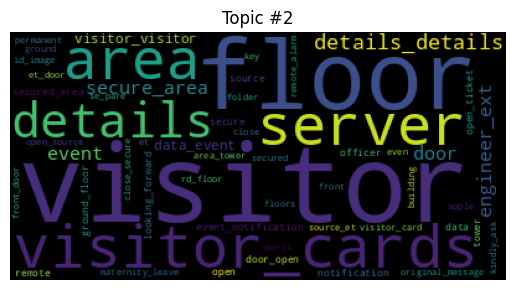

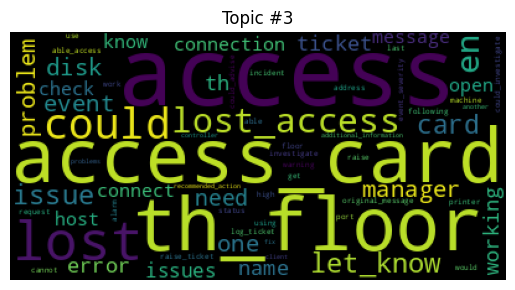

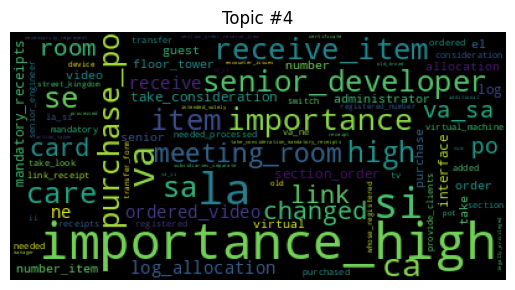

In [ ]:
for t in range(label_lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(label_lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [ ]:
label_ldamulti_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=num_topics,
                         eta=eta_label,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         eval_every = eval_every,
                         random_state=42,
                         per_word_topics=True)

In [ ]:
for num, params in label_ldamulti_model.print_topics():
    print(f'{num}: {params}\n')

0: 0.012*"leaver" + 0.012*"form" + 0.012*"senior_engineer" + 0.011*"engineer" + 0.010*"attached" + 0.009*"senior" + 0.009*"senior_developer" + 0.009*"find_attached" + 0.008*"let" + 0.008*"assigned"

1: 0.049*"laptop" + 0.044*"purchase_po" + 0.039*"receive_item" + 0.029*"link" + 0.028*"item" + 0.025*"receive" + 0.024*"log_allocation" + 0.023*"po" + 0.023*"ordered_video" + 0.022*"changed"

2: 0.022*"importance_high" + 0.015*"issue" + 0.013*"en" + 0.013*"could" + 0.012*"working" + 0.011*"let_know" + 0.009*"high" + 0.009*"engineer" + 0.009*"server" + 0.009*"issues"

3: 0.048*"access" + 0.032*"event" + 0.031*"th_floor" + 0.024*"access_card" + 0.024*"disk" + 0.021*"name" + 0.020*"lost_access" + 0.019*"floor" + 0.017*"details" + 0.014*"meeting_room"

4: 0.079*"card" + 0.038*"la" + 0.037*"si" + 0.029*"cards" + 0.026*"visitor" + 0.025*"va" + 0.021*"ca" + 0.018*"visitor_cards" + 0.017*"care" + 0.016*"analyst_ext"



In [ ]:
getLDAModelAccuracy(label_ldamulti_model,corpus,data,"Label")

0.4533333333333333

In [ ]:
c_v_coherence_model_labelldamulti = CoherenceModel(model=label_ldamulti_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_labelldamulti = c_v_coherence_model_labelldamulti.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_labelldamulti)


C_V Coherence Score:  0.43950520478779326


In [ ]:
u_mass_coherence_model_lda_multicore = CoherenceModel(model=label_ldamulti_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda_multicore = u_mass_coherence_model_lda_multicore.get_coherence()
print('\nu_mass Coherence Score: ', u_mass_coherence_lda_multicore)


u_mass Coherence Score:  -5.688234680484028


In [ ]:
c_uci_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lda_multicore = c_uci_coherence_model_lda_multicore.get_coherence()
print('\nc_uci Coherence Score: ', c_uci_coherence_lda_multicore)


c_uci Coherence Score:  -4.885510001511655


In [ ]:
c_npmi_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lda_multicore = c_npmi_coherence_model_lda_multicore.get_coherence()
print('\nc_npmi Coherence Score: ', c_npmi_coherence_lda_multicore)


c_npmi Coherence Score:  -0.11892735181292236


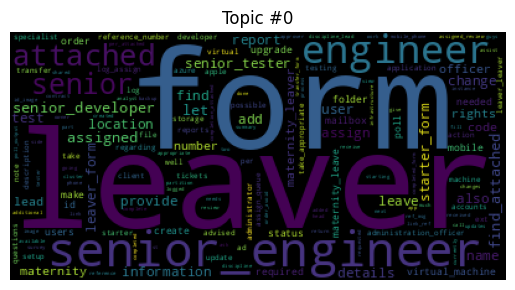

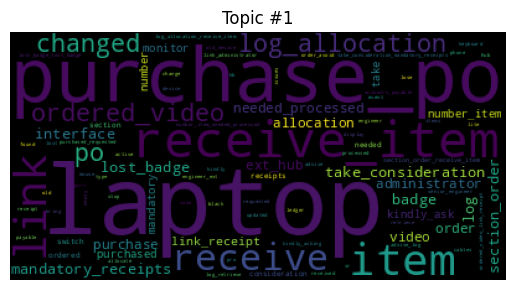

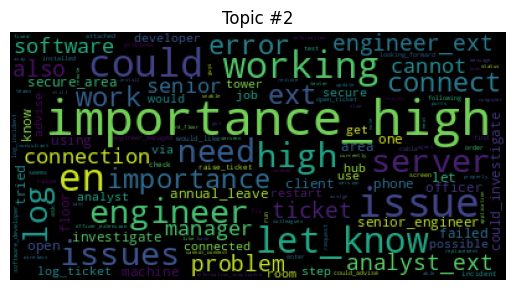

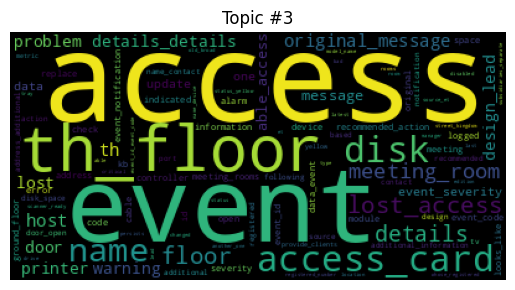

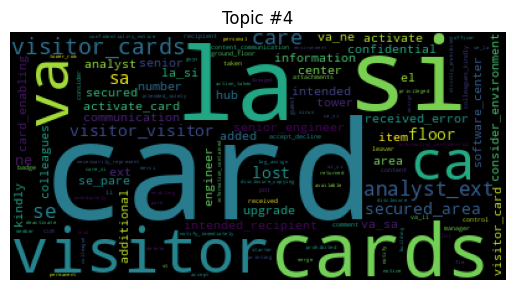

In [ ]:
for t in range(label_ldamulti_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(label_ldamulti_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()